In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from orinoco import (export_edges_to_geodataframe,
                     export_nodes_to_geodataframe,
                     change_tuples_to_vector,
                     get_array_from_features, 
                     apply_func_to_superpixels,
                     get_extent,
                     rasterize_shapes_to_array,
                     get_k_hop_neighborhood,
                     )
from skimage.color import label2rgb
import random
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm
import scipy.ndimage as nd
import scipy

# Read Products

In [2]:
tile_name = 'NR08'

In [3]:
out = Path('out')
out.mkdir(exist_ok=True)

grwl_data = Path('grwl_data')

tile_dir = Path(f'out/{tile_name}')
tile_dir.exists()

True

In [4]:
plot_dir = Path(f'plot/width_analysis_{tile_name}')
plot_dir.mkdir(exist_ok=True, parents=True)

In [5]:
with rasterio.open(tile_dir/f'segments_{tile_name}.tif') as ds:
    segments = ds.read(1)
    profile = ds.profile
    
with rasterio.open(tile_dir/f'segments_rgb_{tile_name}.tif') as ds:
    segments_rgb = ds.read().transpose([1, 2, 0])
with rasterio.open(tile_dir/f'water_mask_{tile_name}.tif') as ds:
    water_mask = ds.read(1)

In [6]:
rivG = nx.read_gpickle(tile_dir/f'{tile_name}_network.pkl')

In [7]:
profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 3550, 'height': 5555, 'count': 1, 'crs': CRS.from_epsg(32608), 'transform': Affine(30.0, 0.0, 449535.0,
       0.0, -30.0, 7709595.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

# Get Extent to crop GRWL

We clipped the extent to reflect are area of interest previously. This profile reflects this.

In [8]:
extent = get_extent(profile['transform'], profile['width'], profile['height'])
extent

[449535.0, 556035.0, 7709595.0, 7542945.0]

In [9]:
edges_orinoco = gpd.read_file(tile_dir/f'{tile_name}_edges.geojson')

In [10]:
edges_grwl = gpd.read_file(grwl_data/'centerlines'/tile_name).to_crs(edges_orinoco.crs)

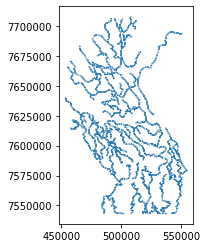

In [11]:
edges_grwl_c = edges_grwl.cx[extent[0]: extent[1], extent[3]: extent[2]]
edges_grwl_c.plot()

# Get Raster of Widths

In [12]:
widths_raster_grwl = rasterize_shapes_to_array(edges_grwl_c.geometry.buffer(1e-7).tolist(),
                                               edges_grwl_c.width_m.tolist(),
                                               profile,
                                               all_touched=True)
widths_raster_grwl[widths_raster_grwl == 0] = np.nan

# Get Segment Average of GRWL Widths

In [13]:
def nan_mean(arr):
    nan_indices = np.isnan(arr)
    if np.sum(~nan_indices) > 0:
        return np.mean(arr[~nan_indices])
    else:
        return np.nan

In [14]:
width_features_grwl = apply_func_to_superpixels(nan_mean, segments, widths_raster_grwl)

# Get Segment with from Orinoco

In [15]:
nodes_orinoco = gpd.read_file(tile_dir/f'{tile_name}_nodes.geojson')
print(nodes_orinoco.shape)
nodes_orinoco.head()

(24592, 18)


,label,meters_to_interface,x,y,interface_adj,graph_degree,width_from_segment,width_m,cc_id,flow_vector_perp_grad_x,flow_vector_perp_grad_y,flow_vector_network_x,flow_vector_network_y,flow_vector_perp_network_x,flow_vector_perp_network_y,flow_vector_perp_x,flow_vector_perp_y,geometry
0,124,3849.722259,507790.851064,7.703858e+06,False,3,812.140131,1304.913043,NaN,0.611346,-0.791363,0.739238,-0.226541,0.226541,0.739238,0.611346,-0.791363,POINT (507790.8510638298 7703858.191489362)
1,118,3876.732079,507384.036145,7.704282e+06,False,2,453.735465,495.737571,NaN,0.796105,0.605159,0.803577,-0.588304,0.588304,0.803577,0.796105,0.605159,POINT (507384.0361445783 7704282.469879518)
2,114,3718.138263,507251.823529,7.704370e+06,False,2,486.139516,502.255840,NaN,0.836227,0.548383,0.751294,-0.648252,0.648252,0.751294,0.836227,0.548383,POINT (507251.8235294117 7704370.05882353)
3,99,3566.153381,507149.634146,7.704483e+06,False,2,479.116882,476.738165,NaN,0.842198,0.539169,0.708232,-0.704053,0.704053,0.708232,0.842198,0.539169,POINT (507149.6341463415 7704482.560975609)
4,93,3406.954511,507030.903614,7.704589e+06,False,2,438.614981,507.654737,NaN,0.868924,0.494945,0.744433,-0.667694,0.667694,0.744433,0.868924,0.494945,POINT (507030.9036144578 7704588.614457832)


We can consider two cases:

1. All nodes from orinoco
2. Excluding nodes within a 1-hop distance from a junction.

The latter will have lower errors.

In [16]:
degree_dict = dict(nx.degree(rivG))
node_to_label = nx.get_node_attributes(rivG, 'label')
junctions = [node for node, degree in degree_dict.items() if degree > 2]
neighborhood_of_junctions = list(set([node_to_label[neighbor] 
                                      for node in junctions 
                                      for neighbor in get_k_hop_neighborhood(rivG, node, radius=1)]))

In [17]:
nodes_orinoco_no_junctions = nodes_orinoco[~nodes_orinoco.label.isin(neighborhood_of_junctions)].copy()
print(nodes_orinoco_no_junctions.shape)

(19780, 18)


Populate the segments using a lookup table from our network. See the comment to switch between cases.

In [18]:
# To switch between cases
# select either 1. nodes_orinoco or 2. nodes_orinoco_no_junctions

df = nodes_orinoco_no_junctions.copy() # can be: 1. nodes_orinoco or 2. nodes_orinoco_no_junctions

label_to_width_dict = df.set_index('label').to_dict()['width_m']
def lookup_width(segment):
    label = segment.ravel()[0]
    return label_to_width_dict.get(label, np.nan)

label_to_width_segment_dict = df.set_index('label').to_dict()['width_from_segment']
def lookup_width_segment(segment):
    label = segment.ravel()[0]
    return label_to_width_segment_dict.get(label, np.nan)

In [19]:
width_features_orinoco = apply_func_to_superpixels(lookup_width, segments, segments)
width_features_from_segment = apply_func_to_superpixels(lookup_width_segment, segments, segments)

Indeed the shapes from the GRWL segments and the Orinoco segments are the same.

In [20]:
width_features_orinoco.shape, width_features_grwl.shape

((26400, 1), (26400, 1))

# Width Comparison

In [31]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', family='serif', size=25)

In [51]:
x = width_features_orinoco.ravel()
y = width_features_grwl.ravel()

ind = (~np.isnan(x) 
       & ~np.isnan(y) 
      )

x = x[ind].copy()
y = y[ind].copy()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

bias = np.mean(x-y)
nbias = np.mean(x-y)/ np.mean(y) * 100
rmse = np.sqrt(np.mean((x-y)**2))
nrmse = np.sqrt(np.mean((x-y)**2)) / np.mean(y) * 100
slope = slope
intercept = intercept
r = r_value
r2 = r_value**2
mad = np.mean(np.abs(x - y))
nmad = np.mean(np.abs(x - y)) / np.mean(y) * 100
count = y.size

bias, nbias, rmse, nrmse, slope, intercept, r, r2, mad, nmad, count

(4.548325791436819,
 1.3466015700601226,
 162.71523255443995,
 48.174338795833926,
 1.0066249430506717,
 -6.816120764041216,
 0.938798300978223,
 0.8813422499195982,
 44.11467710630464,
 13.060826373934646,
 10745)

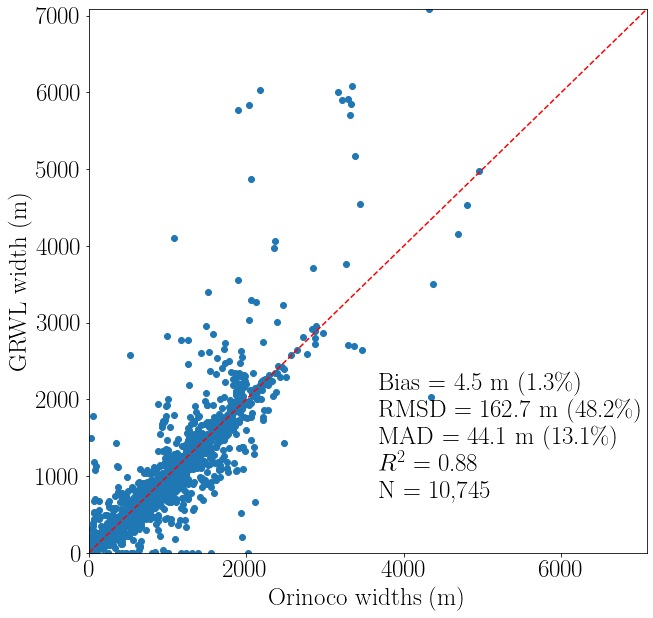

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y)

limit = max(x.max(), y.max())
xx = np.linspace(0, limit, 100)
plt.plot(xx, xx, '--', c='red')
ax.set_xlabel('Orinoco widths (m)')
ax.set_ylabel('GRWL width (m)')
ax.set_xlim(0, limit)
ax.set_ylim(0, limit)

ax.text(.52, .3, f'Bias = {bias:1.1f} m ({nbias:1.1f}\%)', transform=ax.transAxes)
ax.text(.52, .25, f'RMSD = {rmse:1.1f} m ({nrmse:1.1f}\%)', transform=ax.transAxes)
ax.text(.52, .2, f'MAD = {mad:1.1f} m ({nmad:1.1f}\%)', transform=ax.transAxes)
ax.text(.52, .15, f'$R^2$ = {r2:1.2f}', transform=ax.transAxes)
ax.text(.52, .1, f'N = {count:,}', transform=ax.transAxes)
plt.savefig(plot_dir/'width_final.png')

In [53]:
x = width_features_from_segment.ravel()
y = width_features_grwl.ravel()

ind = (~np.isnan(x) 
       & ~np.isnan(y) 
      )

x = x[ind].copy()
y = y[ind].copy()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

bias = np.mean(x-y)
nbias = np.mean(x-y)/ np.mean(y) * 100
rmse = np.sqrt(np.mean((x-y)**2))
nrmse = np.sqrt(np.mean((x-y)**2)) / np.mean(y) * 100
slope = slope
intercept = intercept
r = r_value
r2 = r_value**2
mad = np.mean(np.abs(x - y))
nmad = np.mean(np.abs(x - y)) / np.mean(y) * 100
count = y.size

bias, nbias, rmse, nrmse, slope, intercept, r, r2, mad, nmad, count

(-31.204454362143906,
 -9.23855703477615,
 171.43362056346382,
 50.75555120666173,
 1.1045829495634067,
 -0.8563730793792956,
 0.9382972431017816,
 0.880401716412404,
 43.94119207271447,
 13.00946347045612,
 10745)

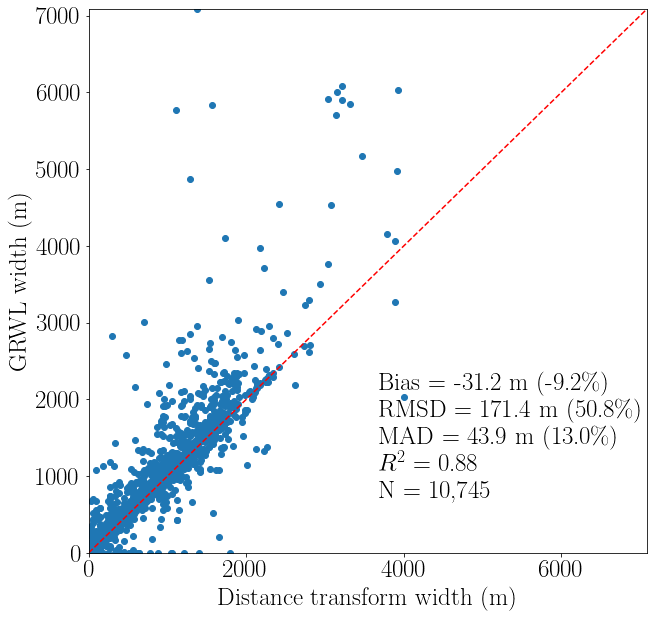

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y)

limit = max(x.max(), y.max())
xx = np.linspace(0, limit, 100)
plt.plot(xx, xx, '--', c='red')
ax.set_xlabel('Distance transform width (m)')
ax.set_ylabel('GRWL width (m)')
ax.set_xlim(0, limit)
ax.set_ylim(0, limit)

ax.text(.52, .3, f'Bias = {bias:1.1f} m ({nbias:1.1f}\%)', transform=ax.transAxes)
ax.text(.52, .25, f'RMSD = {rmse:1.1f} m ({nrmse:1.1f}\%)', transform=ax.transAxes)
ax.text(.52, .2, f'MAD = {mad:1.1f} m ({nmad:1.1f}\%)', transform=ax.transAxes)
ax.text(.52, .15, f'$R^2$ = {r2:1.2f}', transform=ax.transAxes)
ax.text(.52, .1, f'N = {count:,}', transform=ax.transAxes)
plt.savefig(plot_dir/'width_dt.png')

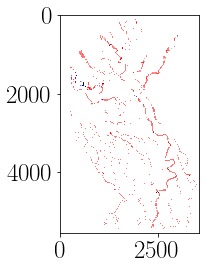

In [36]:
diff_features = width_features_orinoco - width_features_grwl
diff_array = get_array_from_features(segments, diff_features)
plt.imshow(diff_array, cmap='seismic')

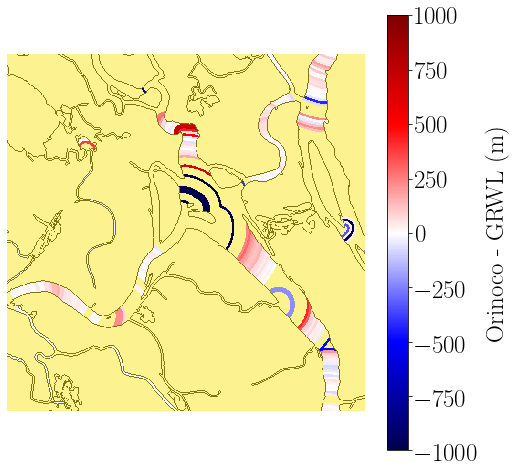

In [27]:
plt.figure(figsize=(8, 8))
index = np.s_[1750:2500, 1500:2250]
diff_crop = diff_array[index]
mask_crop = water_mask[index]
outline = nd.morphology.binary_dilation(mask_crop, iterations = 2).astype(float)
outline[mask_crop.astype(bool)] = 0.
#outline[~mask_crop.astype(bool)] = np.nan

nan_values = np.isnan(diff_crop).astype(float)
nan_values[nan_values == 0] = np.nan

plt.imshow(nan_values, cmap='viridis_r')
plt.imshow(outline, cmap='binary', alpha=.5)

plt.imshow(diff_crop, cmap='seismic', vmin=-1000, vmax=1000)
plt.axis('off')

plt.colorbar(label='Orinoco - GRWL (m)')

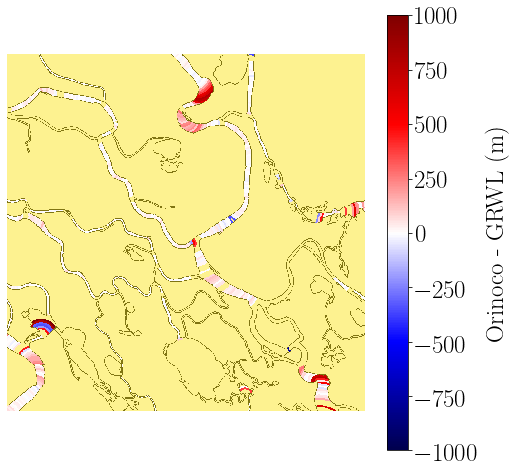

In [28]:
plt.figure(figsize=(8, 8))
index = np.s_[1000:2000, 1000:2000]
diff_crop = diff_array[index]
mask_crop = water_mask[index]
outline = nd.morphology.binary_dilation(mask_crop, iterations = 2).astype(float)
outline[mask_crop.astype(bool)] = 0.
#outline[~mask_crop.astype(bool)] = np.nan

nan_values = np.isnan(diff_crop).astype(float)
nan_values[nan_values == 0] = np.nan

plt.imshow(nan_values, cmap='viridis_r')
plt.imshow(outline, cmap='binary', alpha=.5)

plt.imshow(diff_crop, cmap='seismic', vmin=-1000, vmax=1000)
plt.axis('off')
plt.colorbar(label='Orinoco - GRWL (m)')

In [29]:
p = profile.copy()
p['dtype'] = 'float32'
p['nodata'] = np.nan
with rasterio.open(tile_dir/f'width_differences.tif', 'w', **p) as ds:
    ds.write(diff_array.astype(np.float32), 1)